In [35]:
import numpy as np
import xarray as xr
import pandas as pd
from typing import Final
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
GSP_PV_FILENAME: Final[str] = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
ds = xr.open_dataset(GSP_PV_FILENAME, engine="zarr")
ds

<xarray.Dataset>
Dimensions:                (datetime_gmt: 150865, gsp_id: 318)
Coordinates:
  * datetime_gmt           (datetime_gmt) datetime64[ns] 2014-01-01 ... 2022-...
  * gsp_id                 (gsp_id) int64 0 1 2 3 4 5 ... 313 314 315 316 317
Data variables:
    generation_mw          (datetime_gmt, gsp_id) float64 ...
    installedcapacity_mwp  (datetime_gmt, gsp_id) float64 ...

In [48]:
updated_national_mw = ds.sel(gsp_id=0)["generation_mw"].to_series()

In [53]:
updated_sum_of_gsps_mw = ds.sel(gsp_id=range(1,318))["generation_mw"].sum("gsp_id")
updated_sum_of_gsps_mw

<xarray.DataArray 'generation_mw' (datetime_gmt: 150865)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * datetime_gmt  (datetime_gmt) datetime64[ns] 2014-01-01 ... 2022-08-10

In [9]:
INTRADAY_PV_FILENAME: Final[str] = "~/data/PV/PV_Live/intraday_national/intra-pv2.csv"
intraday_df = pd.read_csv(INTRADAY_PV_FILENAME, index_col="datetime_utc", parse_dates=["datetime_utc", "created_utc"])
intraday_df

,created_utc,regime,solar_generation_kw,location_id,gsp_name,region_name,installed_capacity_mw
datetime_utc,,,,,,,
2022-06-14 08:00:00,2022-06-14 08:34:12.135340+00:00,in-day,3670000.0,1,National,National,13861
2022-06-14 08:30:00,2022-06-14 08:40:12.756287+00:00,in-day,4390000.0,1,National,National,13861
2022-06-14 09:00:00,2022-06-14 09:10:10.836682+00:00,in-day,5020000.0,1,National,National,13861
2022-06-14 09:30:00,2022-06-14 09:40:15.579088+00:00,in-day,5420000.0,1,National,National,13861
2022-06-14 10:00:00,2022-06-14 10:10:12.820550+00:00,in-day,5760000.0,1,National,National,13861
...,...,...,...,...,...,...,...
2023-04-25 08:00:00,2023-04-25 08:07:05.508671+00:00,in-day,3808430.0,1,National,National,13861
2023-04-25 08:30:00,2023-04-25 08:40:06.281648+00:00,in-day,4683150.0,1,National,National,13861
2023-04-25 09:00:00,2023-04-25 09:07:04.951027+00:00,in-day,5518970.0,1,National,National,13861


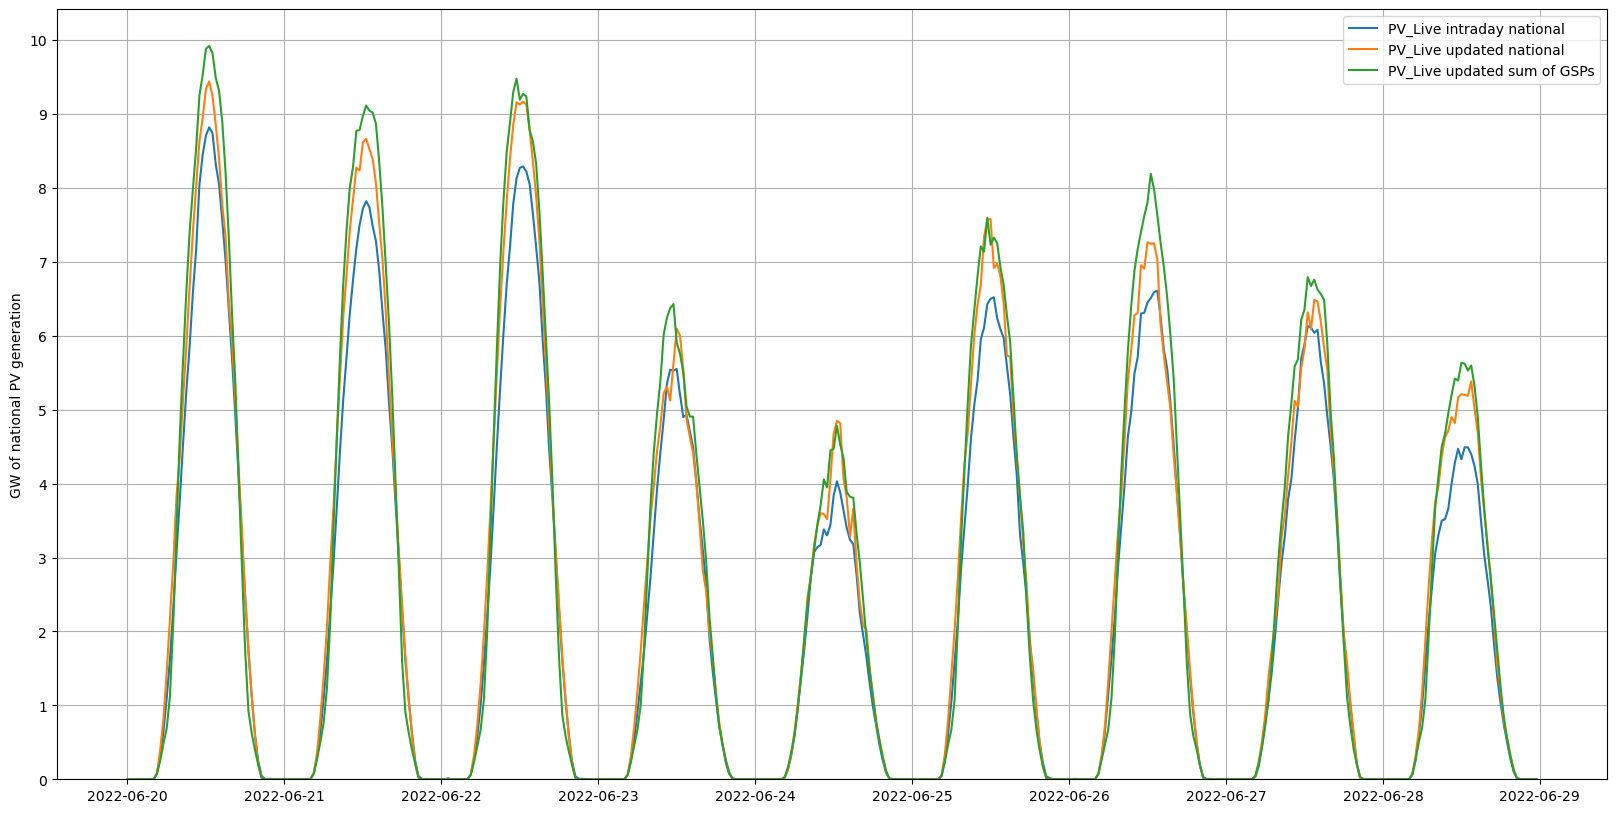

In [59]:
START_DATE: Final[str] = "2022-06-20"
END_DATE: Final[str] = "2022-06-28" # "2022-08-10"  # The last date in v5 of the GSP PV data

fig, ax = plt.subplots()

ax.plot(
    intraday_df["solar_generation_kw"].loc[START_DATE:END_DATE] / 1E6,
    label="PV_Live intraday national",
)

ax.plot(
    updated_national_mw.loc[START_DATE:END_DATE] / 1E3,
    label="PV_Live updated national",
)

ax.plot(
    updated_sum_of_gsps_mw.loc[START_DATE:END_DATE].to_series() / 1E3,
    label="PV_Live updated sum of GSPs",
)

ax.legend()
ax.grid()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel("GW of national PV generation")
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))